In [81]:
!pip install xgboost

In [82]:
# Imports

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
import joblib
import matplotlib.pyplot as plt
%matplotlib inline

In [83]:
# Load the train and test sets
train = pd.read_csv('./train_preproc.csv', sep=';')
test = pd.read_csv('./test_preproc.csv', sep=';')

In [84]:
# Check for null values after preprocessing
print(train.isnull().sum())
print(test.isnull().sum())

rating    0
text      1
dtype: int64
rating    0
text      1
dtype: int64


In [85]:
# Remove NaN
train = train.replace('', np.nan).dropna()
test = test.replace('', np.nan).dropna()

In [86]:
print(train.isnull().sum())
print(test.isnull().sum())

rating    0
text      0
dtype: int64
rating    0
text      0
dtype: int64


In [87]:
# Split into target and feature
X_train = train['text']
y_train = train['rating']

X_test = test['text']
y_test = test['rating']

In [88]:
#Final train and test sizes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13435,)
(3358,)
(13435,)
(3358,)


### Feature extraction (unigrams)

In [89]:
# Set a vectorizer instance
vectorizer = CountVectorizer(
    ngram_range=(1, 1), # unigrams
    max_df = 0.9,
    min_df=5,
    max_features = 2500
)

In [90]:
# Vectorize X
X_train_cv = vectorizer.fit_transform(X_train.values)
X_test_cv = vectorizer.transform(X_test)

In [91]:
# Print the vocabulary size
print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")

Vocabulary size: 2500


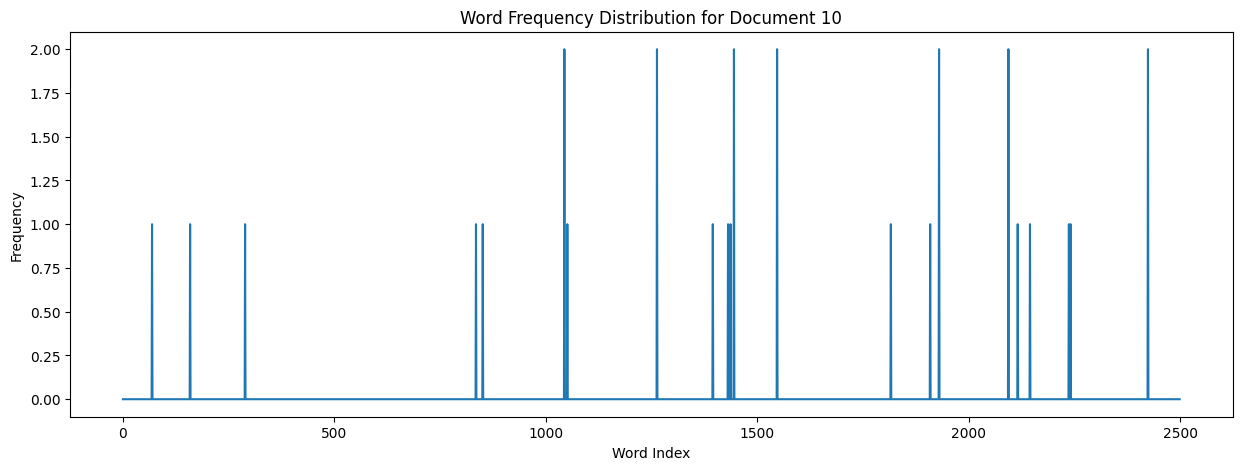

Top words and frequencies in the sample document:
stay: 2
set: 2
hole: 2
not: 2
lock: 2
peg: 2
way: 2
thick: 1
new: 1
fitting: 1


In [92]:
# Extract feature names (vocabulary)
feature_names = vectorizer.get_feature_names_out()

# Select a document for visualization
sample_idx = 10
sample_features = X_train_cv[sample_idx].toarray().flatten()

# Plot all features (word frequencies)
plt.figure(figsize=(15, 5))
plt.plot(range(len(sample_features)), sample_features)
plt.title(f'Word Frequency Distribution for Document {sample_idx}')
plt.xlabel('Word Index')
plt.ylabel('Frequency')
plt.show()

# Highlight top words with highest frequencies
top_word_indices = np.argsort(sample_features)[::-1][:10]  # Top 10 word indices
top_words = [(feature_names[i], sample_features[i]) for i in top_word_indices if sample_features[i] > 0]

print("Top words and frequencies in the sample document:")
for word, freq in top_words:
    print(f"{word}: {freq}")


<b>Comment: </b> The frequency plot shows that only a few words have non-zero frequencies, and their frequency values range from 1 to 2. This suggests that the document relies on a limited set of words repeatedly.

Setting the min_df to 1% of the corpus, leaves vocabulary size at roughly 300 features. This means that the corpus likely has a large proportion of words that occur in very few documents and a smaller subset of words that are more consistent and occur across multiple documents. I will keep min_df=5.

As stopwords were removed in the previous step, the max_df was set to 0.9 to exclude high frequency words, which are not functional words,  but appear in more than 90% of the samples.

Given the sample size of roughly 13 500 samples, only 2 500 were selected for classification to exlude reduntant features and keep lower dimensionality of the data.

### Modeling: Random Forest Classifier

In [93]:
# Define the parameter grid
max_depth = range(1, 15)
n_estimators = range(100, 1001, 50)
tuned_parameters = {'max_depth': max_depth, 'n_estimators': n_estimators}

# Initialize GridSearchCV with RandomForestClassifier
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=0),
    scoring='accuracy',
    param_grid=tuned_parameters,
    cv=5,
    verbose=2
)

# Fit using the vectorized training data
grid_rf.fit(X_train_cv, y_train)

print("Best mean cross-validation score: {:.3f}".format(grid_rf.best_score_))
print("Best parameters: {}".format(grid_rf.best_params_))

Fitting 5 folds for each of 266 candidates, totalling 1330 fits
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=150; total time=   0.3s
[CV] END ......................max_depth=1, n_estimators=150; total time=   0.3s
[CV] END ......................max_depth=1, n_estimators=150; total time=   0.3s
[CV] END ......................max_depth=1, n_estimators=150; total time=   0.3s
[CV] END ......................max_depth=1, n_estimators=150; total time=   0.3s
[CV] END ......................max_depth=1, n_estimators=200; total time=   0.4s
[CV] END ......................max_depth=1, n

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best mean cross-validation score: 0.445
Best parameters: {'max_depth': 14, 'n_estimators': 600}


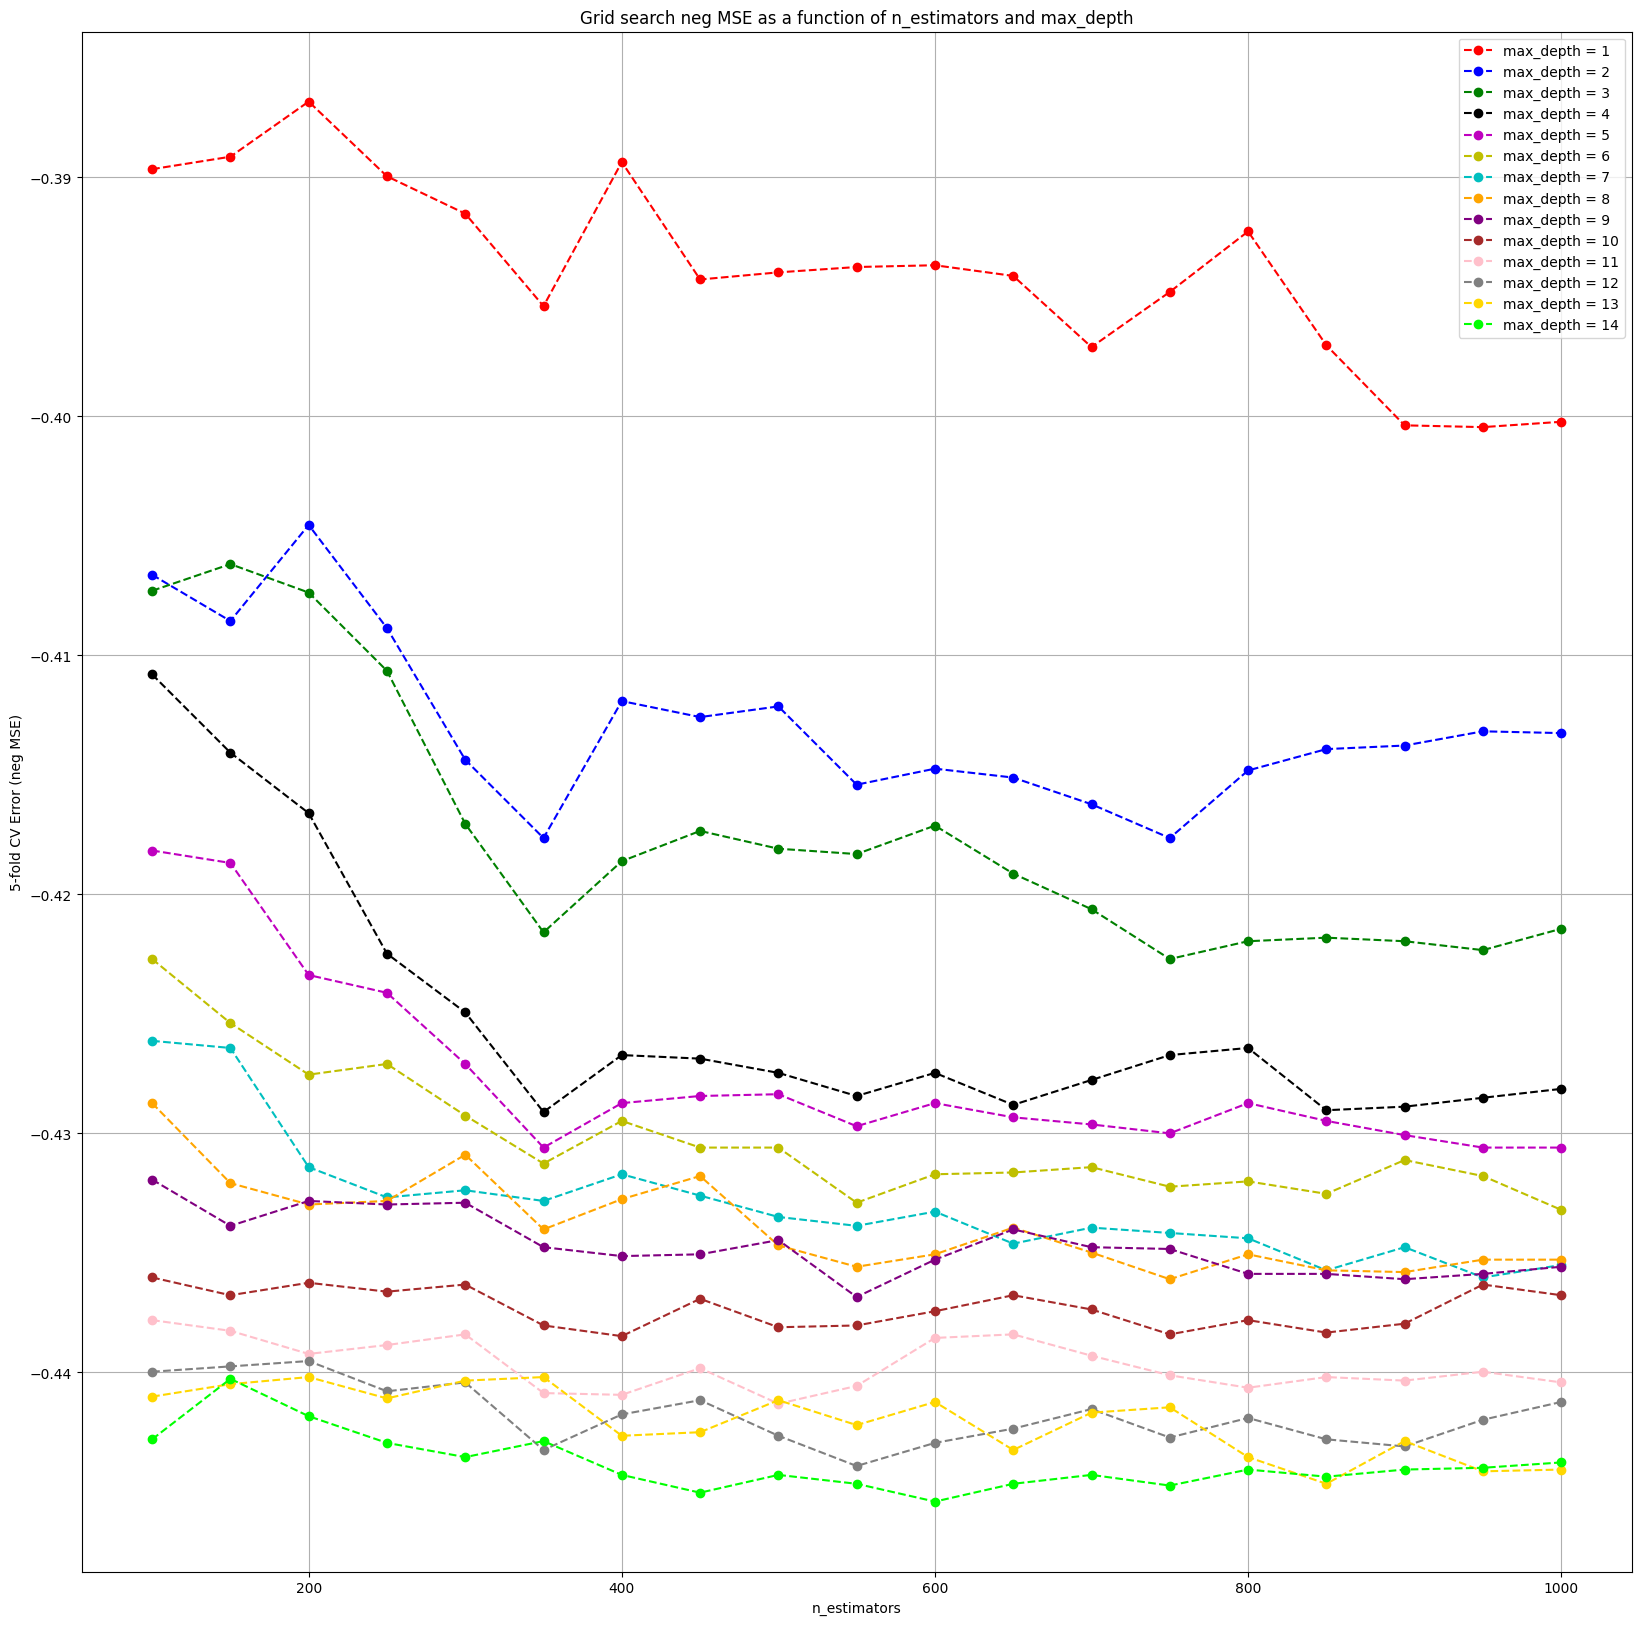

In [94]:
# Plot the mean test scores evolution against tuned parameters
error = -1*grid_rf.cv_results_['mean_test_score'].reshape(len(max_depth), len(n_estimators))
colors = ['r', 'b', 'g', 'k', 'm', 'y', 'c', 'orange', 'purple', 'brown', 'pink', 'gray', 'gold', 'lime']
plt.figure(figsize=(20, 20))

for i, depth in enumerate(max_depth):
    plt.plot(n_estimators, error[i, :], linestyle='--', marker='o', color=colors[i % len(colors)], label='max_depth = %g' % depth)

plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('5-fold CV Error (neg MSE)')
plt.grid()
plt.title('Grid search neg MSE as a function of n_estimators and max_depth')
plt.show()

In [95]:
# Retrieve best parameters
maxDepth_best = grid_rf.best_params_['max_depth']
n_estimator_best = grid_rf.best_params_['n_estimators']

# Train the best model
rf_best = RandomForestClassifier(max_depth=maxDepth_best,n_estimators=n_estimator_best)
rf_best.fit(X_train_cv,y_train)

# Print training and testing scores
print("Train: ",rf_best.score(X_train_cv,y_train))
print("Test: ",rf_best.score(X_test_cv,y_test))

Train:  0.6228507629326386
Test:  0.4324002382370459


### Feature extractions: unigrams and bigrams

In [96]:
# Set a vectorizer instance
vectorizer = CountVectorizer(
    ngram_range=(1, 2), # unigrams and bigrams
    max_df = 0.95,
    min_df = 5,
    max_features = 2500
)

In [97]:
# Vectorize X
X_train_cv = vectorizer.fit_transform(X_train.values)
X_test_cv = vectorizer.transform(X_test)

In [98]:
# Print the vocabulary size
print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")

Vocabulary size: 2500


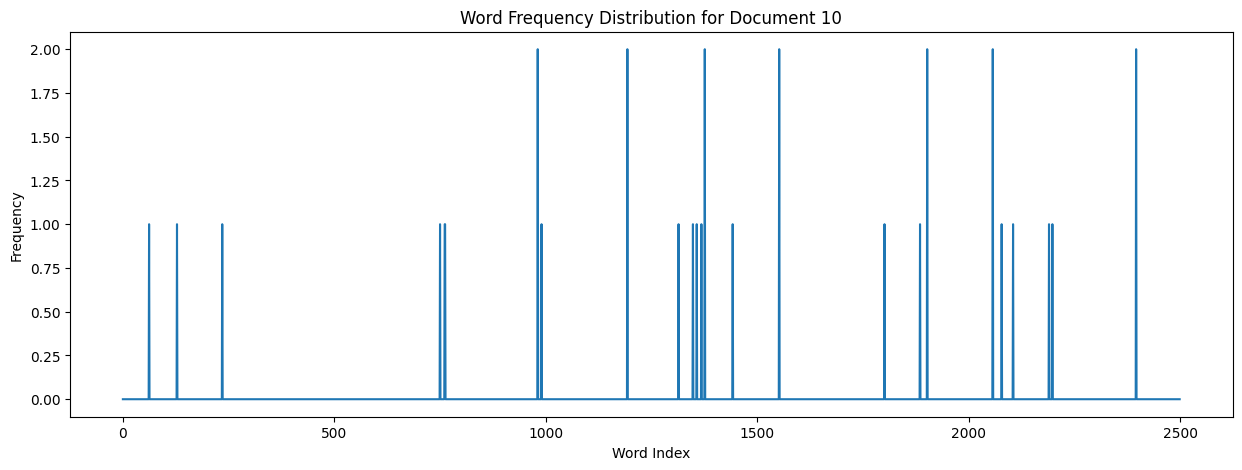

Top words and frequencies in the sample document:
set: 2
stay: 2
lock: 2
not: 2
peg: 2
way: 2
hole: 2
think: 1
new: 1
mold: 1


In [99]:
# Extract feature names (vocabulary)
feature_names = vectorizer.get_feature_names_out()

# Select a document for visualization
sample_idx = 10
sample_features = X_train_cv[sample_idx].toarray().flatten()

# Plot all features (word frequencies)
plt.figure(figsize=(15, 5))
plt.plot(range(len(sample_features)), sample_features)
plt.title(f'Word Frequency Distribution for Document {sample_idx}')
plt.xlabel('Word Index')
plt.ylabel('Frequency')
plt.show()

# Highlight top words with highest frequencies
top_word_indices = np.argsort(sample_features)[::-1][:10]  # Top 10 word indices
top_words = [(feature_names[i], sample_features[i]) for i in top_word_indices if sample_features[i] > 0]

print("Top words and frequencies in the sample document:")
for word, freq in top_words:
    print(f"{word}: {freq}")

###Modelling: Random Forest Classifier

In [100]:
# Define the parameter grid
max_depth = range(1, 15)
n_estimators = range(100, 1001, 50)
tuned_parameters = {'max_depth': max_depth, 'n_estimators': n_estimators}

# Initialize GridSearchCV with RandomForestClassifier
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=0),
    scoring='accuracy',
    param_grid=tuned_parameters,
    cv=5,
    verbose=2
)

# Fit using the vectorized training data
grid_rf.fit(X_train_cv, y_train)

print("Best mean cross-validation score: {:.3f}".format(grid_rf.best_score_))
print("Best parameters: {}".format(grid_rf.best_params_))

Fitting 5 folds for each of 266 candidates, totalling 1330 fits
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=1, n_estimators=150; total time=   0.3s
[CV] END ......................max_depth=1, n_estimators=150; total time=   0.3s
[CV] END ......................max_depth=1, n_estimators=150; total time=   0.3s
[CV] END ......................max_depth=1, n_estimators=150; total time=   0.3s
[CV] END ......................max_depth=1, n_estimators=150; total time=   0.3s
[CV] END ......................max_depth=1, n_estimators=200; total time=   0.4s
[CV] END ......................max_depth=1, n

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best mean cross-validation score: 0.446
Best parameters: {'max_depth': 14, 'n_estimators': 550}


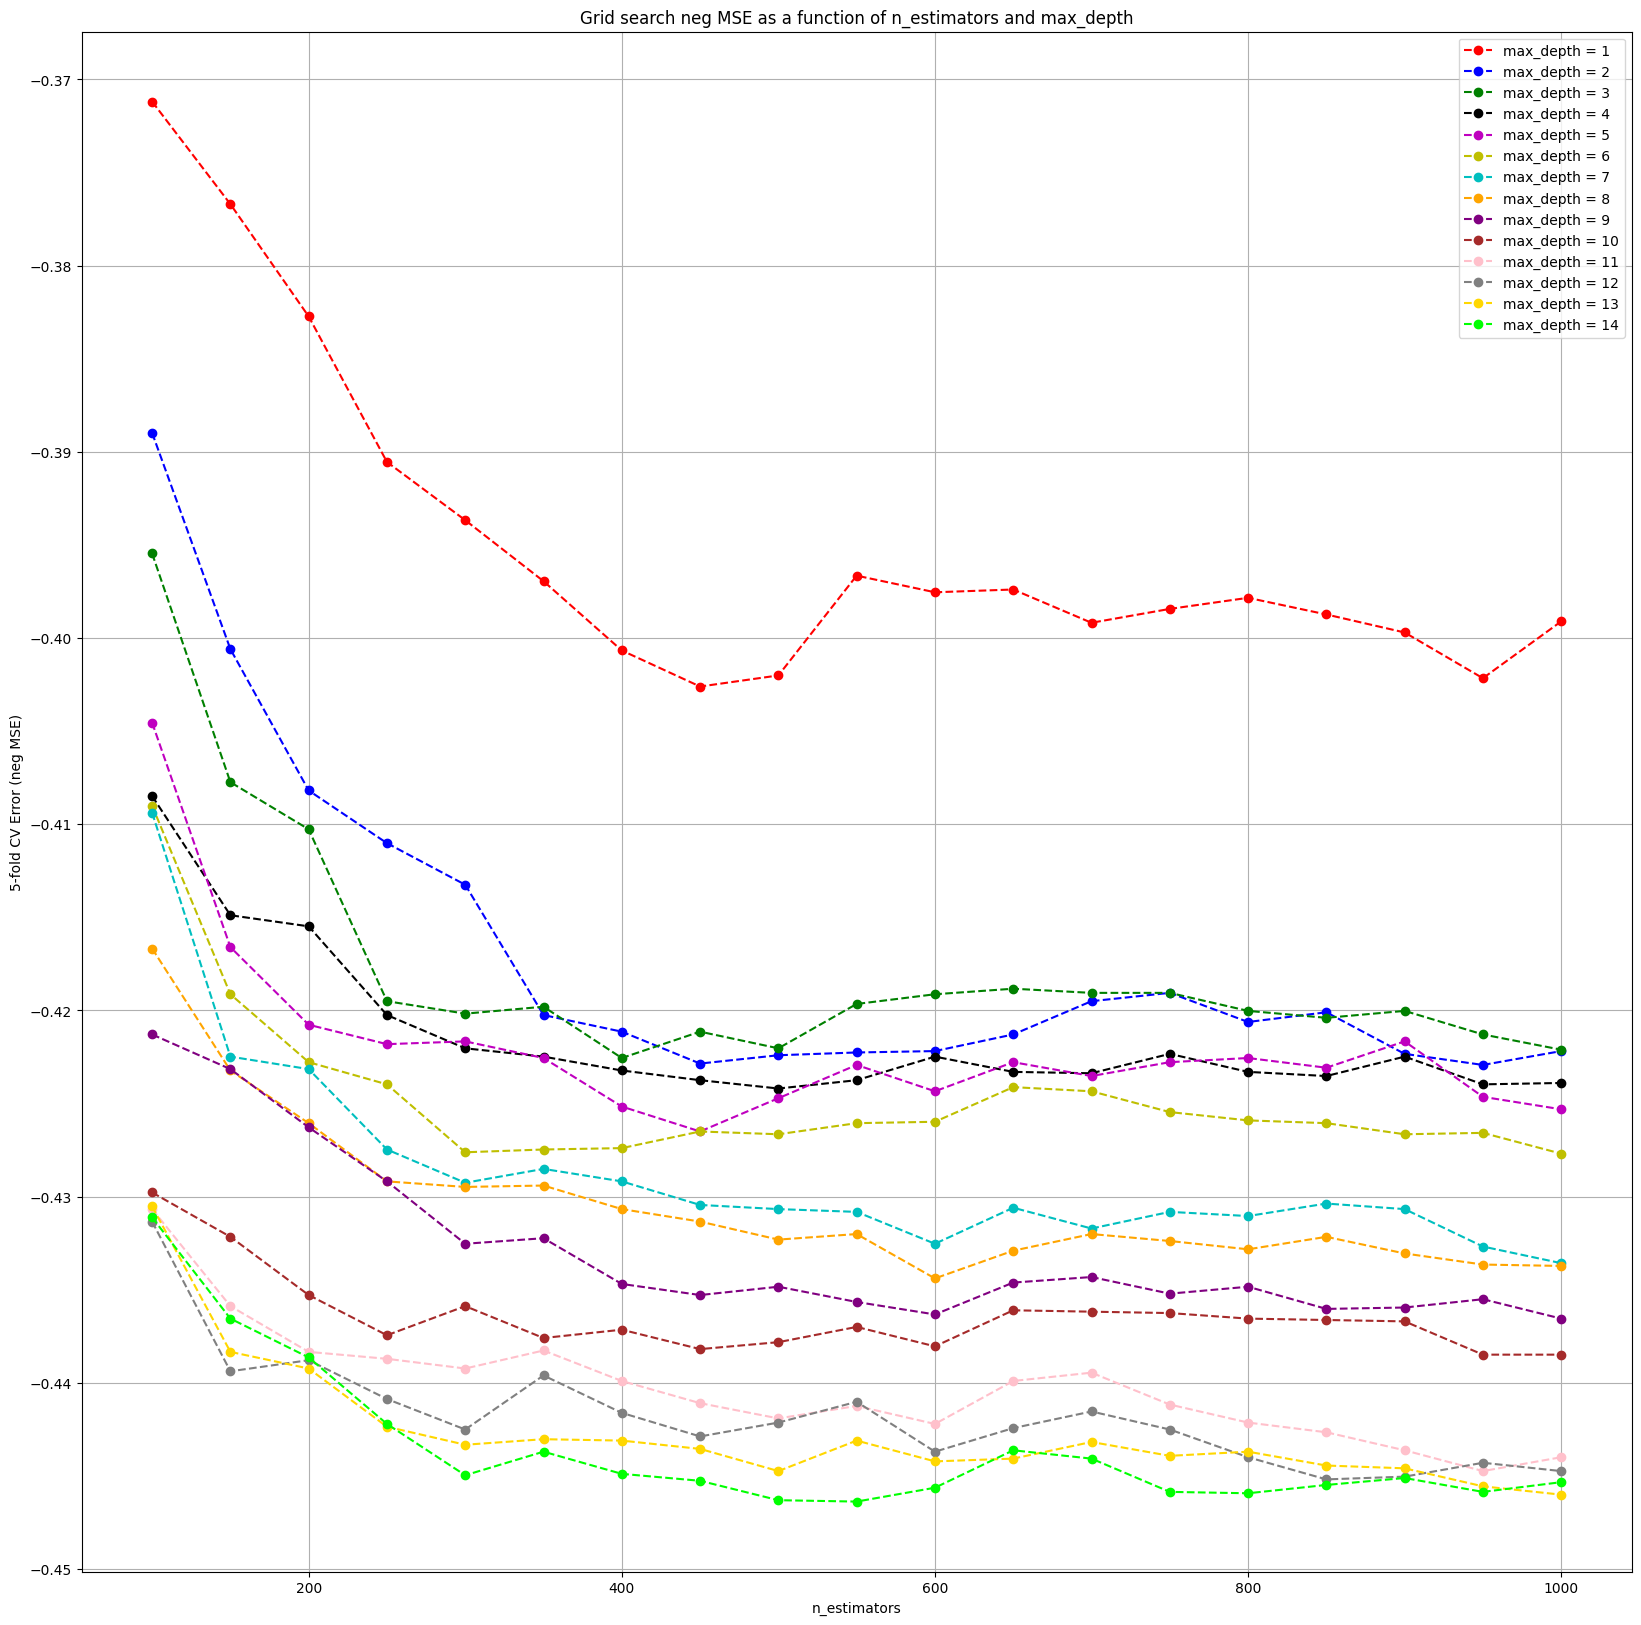

In [101]:
# Plot the mean test scores evolution against tuned parameters
error = -1*grid_rf.cv_results_['mean_test_score'].reshape(len(max_depth), len(n_estimators))
colors = ['r', 'b', 'g', 'k', 'm', 'y', 'c', 'orange', 'purple', 'brown', 'pink', 'gray', 'gold', 'lime']
plt.figure(figsize=(20, 20))

for i, depth in enumerate(max_depth):
    plt.plot(n_estimators, error[i, :], linestyle='--', marker='o', color=colors[i % len(colors)], label='max_depth = %g' % depth)

plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('5-fold CV Error (neg MSE)')
plt.grid()
plt.title('Grid search neg MSE as a function of n_estimators and max_depth')
plt.show()

In [102]:
# Retrieve best parameters
maxDepth_best = grid_rf.best_params_['max_depth']
n_estimator_best = grid_rf.best_params_['n_estimators']

# Train the best model
rf_best = RandomForestClassifier(max_depth=maxDepth_best,n_estimators=n_estimator_best)
rf_best.fit(X_train_cv,y_train)

# Print training and testing scores
print("Train: ",rf_best.score(X_train_cv,y_train))
print("Test: ",rf_best.score(X_test_cv,y_test))

Train:  0.6155563825828061
Test:  0.43299583085169746


###Modelling: Multinomial Naive Bayes

In [103]:
# Define the parameter grid
alpha = np.logspace(-6, 4, 20)
tuned_parameters = {'alpha': alpha}

# Initialize GridSearchCV with MultinomialNB
grid_nb = GridSearchCV(
    MultinomialNB(),
    scoring='accuracy',
    param_grid=tuned_parameters,
    cv=5,
    verbose=2
)

# Fit the model using vectorized training data
grid_nb.fit(X_train_cv, y_train)

# Output the best results
print("Best mean cross-validation score: {:.3f}".format(grid_nb.best_score_))
print("Best parameters: {}".format(grid_nb.best_params_))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ........................................alpha=1e-06; total time=   0.0s
[CV] END ........................................alpha=1e-06; total time=   0.0s
[CV] END ........................................alpha=1e-06; total time=   0.0s
[CV] END ........................................alpha=1e-06; total time=   0.0s
[CV] END ........................................alpha=1e-06; total time=   0.0s
[CV] END ........................alpha=3.359818286283781e-06; total time=   0.0s
[CV] END ........................alpha=3.359818286283781e-06; total time=   0.0s
[CV] END ........................alpha=3.359818286283781e-06; total time=   0.0s
[CV] END ........................alpha=3.359818286283781e-06; total time=   0.0s
[CV] END ........................alpha=3.359818286283781e-06; total time=   0.0s
[CV] END .......................alpha=1.1288378916846883e-05; total time=   0.0s
[CV] END .......................alpha=1.1288378

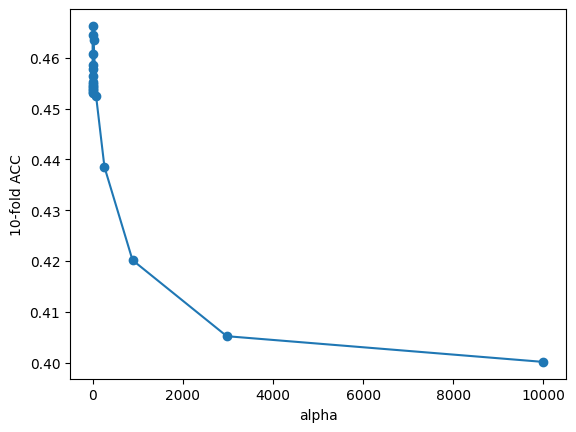

In [104]:
# Plot the mean test scores evolution against the tuned parameter
scores = np.array(grid_nb.cv_results_['mean_test_score'])
plt.plot(alpha,scores,'-o')
plt.xlabel('alpha')
plt.ylabel('10-fold ACC')

plt.show()

In [105]:
# Retrieve best parameters
alpha_best = grid_nb.best_params_['alpha']

# Train the best model
nb_best = MultinomialNB(alpha=alpha_best)
nb_best.fit(X_train_cv,y_train)

# Print training and testing scores
print("Train: ",nb_best.score(X_train_cv,y_train))
print("Test: ",nb_best.score(X_test_cv,y_test))

Train:  0.5817640491254187
Test:  0.46069088743299585


### Modeling: XGBoost

In [106]:
max_depth = range(1, 15)
learning_rate = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
tuned_parameters = {'max_depth': max_depth, 'learning_rate': learning_rate}

grid_xgb = GridSearchCV(XGBClassifier(n_estimators=200, random_state=0),
                    scoring='neg_mean_squared_error',
                    param_grid=tuned_parameters,
                    cv=5,
                    verbose=2)

grid_xgb.fit(X_train_cv, y_train - 1)

print("Best mean cross-validation score: {:.3f}".format(grid_xgb.best_score_))
print("Best parameters: {}".format(grid_xgb.best_params_))

Fitting 5 folds for each of 210 candidates, totalling 1050 fits
[CV] END ..................learning_rate=0.0001, max_depth=1; total time=   1.0s
[CV] END ..................learning_rate=0.0001, max_depth=1; total time=   0.9s
[CV] END ..................learning_rate=0.0001, max_depth=1; total time=   1.2s
[CV] END ..................learning_rate=0.0001, max_depth=1; total time=   0.9s
[CV] END ..................learning_rate=0.0001, max_depth=1; total time=   0.9s
[CV] END ..................learning_rate=0.0001, max_depth=2; total time=   1.3s
[CV] END ..................learning_rate=0.0001, max_depth=2; total time=   1.4s
[CV] END ..................learning_rate=0.0001, max_depth=2; total time=   4.7s
[CV] END ..................learning_rate=0.0001, max_depth=2; total time=   1.3s
[CV] END ..................learning_rate=0.0001, max_depth=2; total time=   1.3s
[CV] END ..................learning_rate=0.0001, max_depth=3; total time=   1.9s
[CV] END ..................learning_rate=0.00

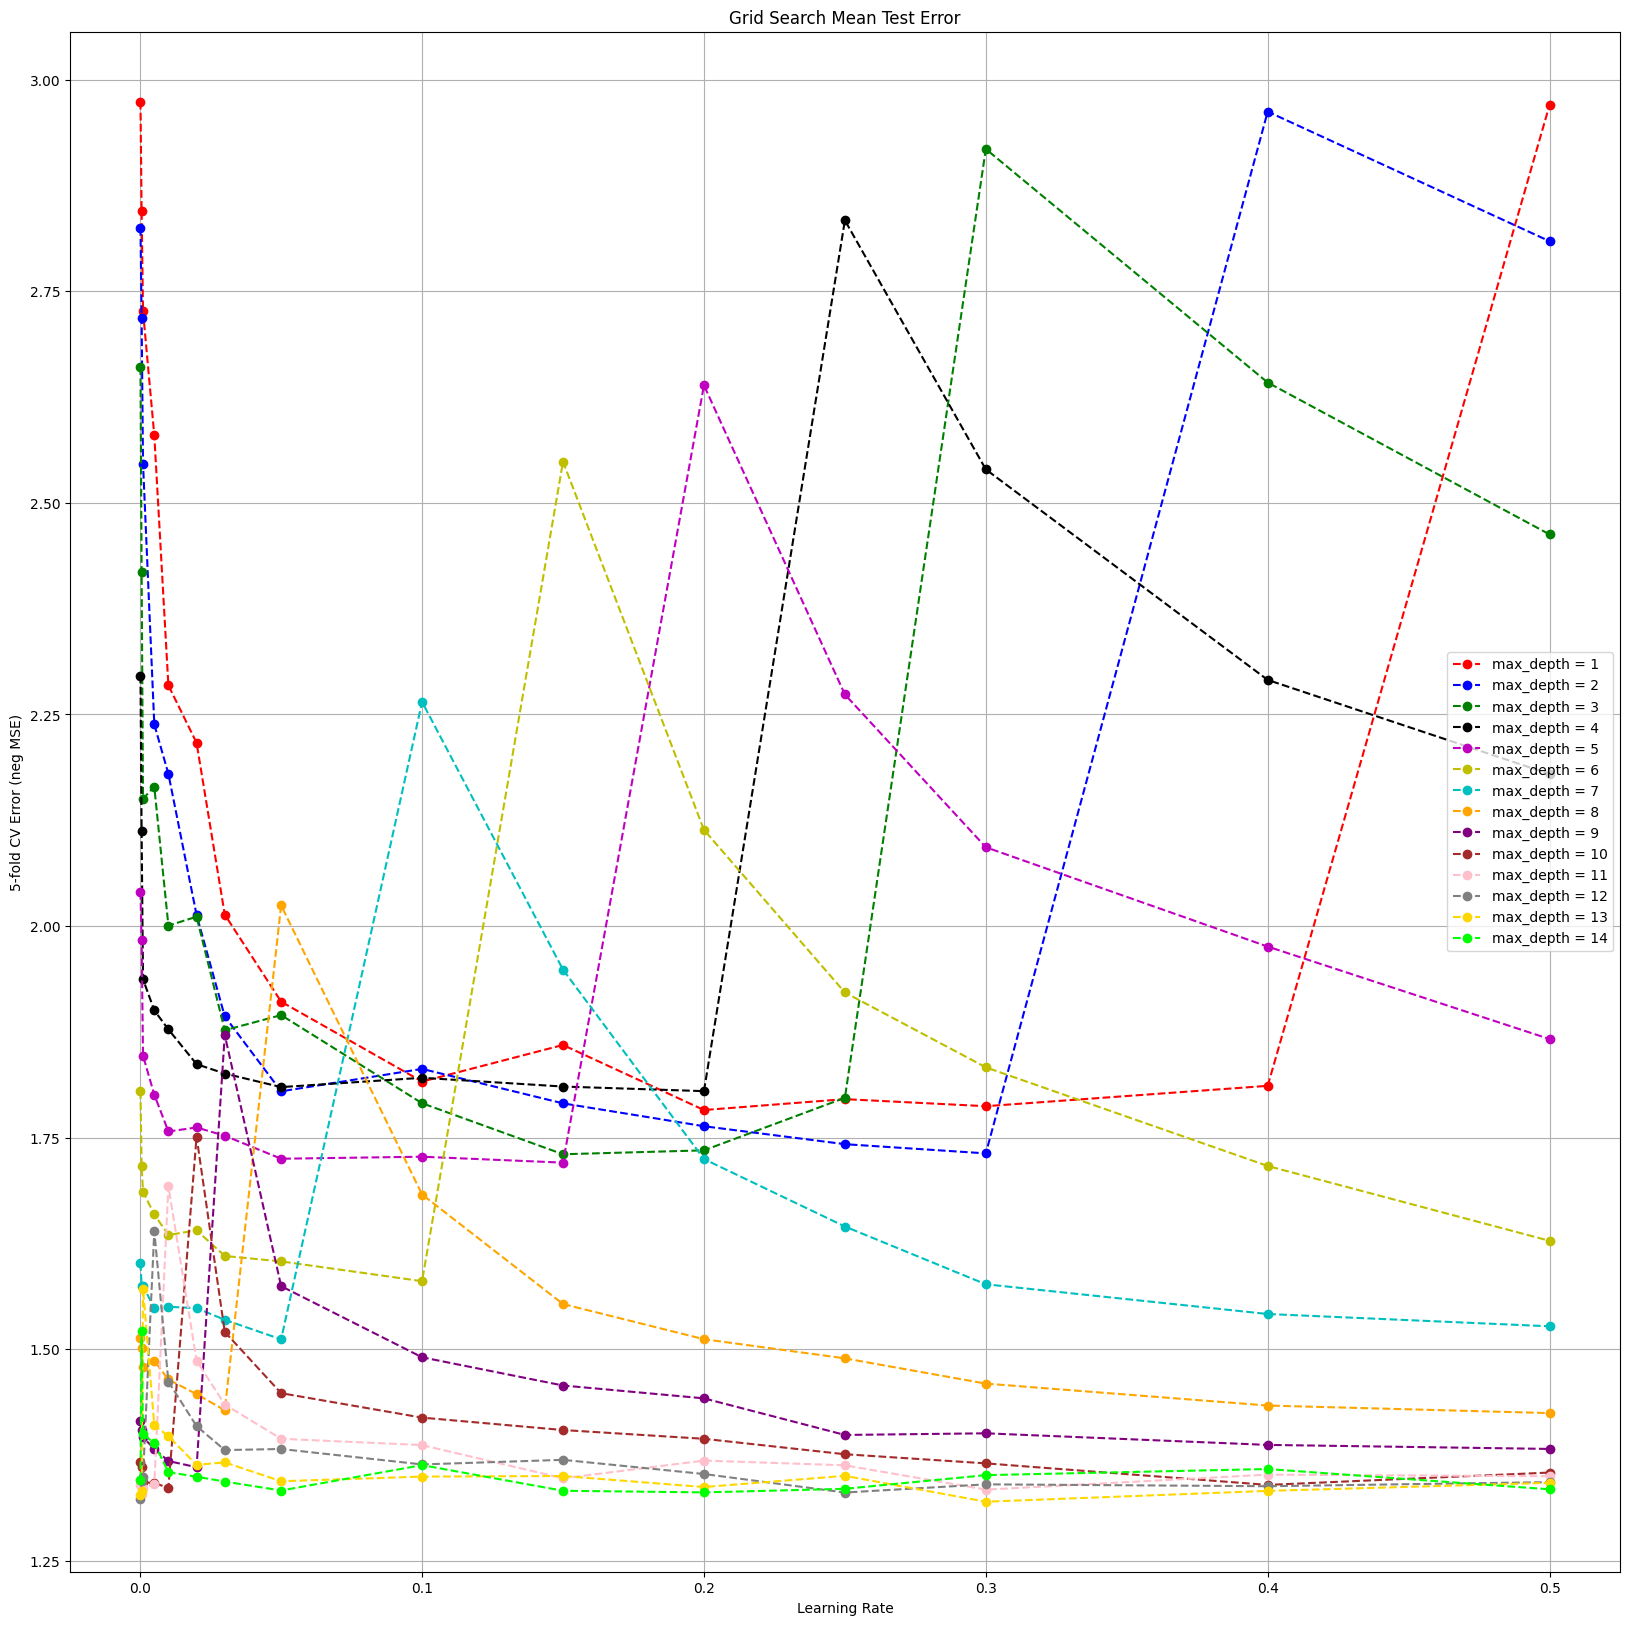

In [107]:
# Plot the mean test scores evolution against tuned parameters
error = -1 * grid_xgb.cv_results_['mean_test_score'].reshape(len(max_depth), len(learning_rate))
colors = ['r', 'b', 'g', 'k', 'm', 'y', 'c', 'orange', 'purple', 'brown', 'pink', 'gray', 'gold', 'lime']
plt.figure(figsize=(20, 20))

for i, depth in enumerate(max_depth):
    plt.plot(learning_rate, error[i, :], linestyle='--', marker='o',
             color=colors[i % len(colors)], label='max_depth = %g' % depth)

plt.legend()
plt.xlabel('Learning Rate')
plt.ylabel('5-fold CV Error (neg MSE)')
plt.grid()
plt.title('Grid Search Mean Test Error')
plt.show()

In [108]:
# Retrieve best parameters
lr_best = grid_xgb.best_params_['learning_rate']
max_depth_best = grid_xgb.best_params_['max_depth']

# Train the best model
xgb_best = XGBClassifier(n_estimators=200,learning_rate=lr_best, max_depth=max_depth_best)
xgb_best.fit(X_train_cv,y_train-1)

# Print training and testing scores
print("Train: ",xgb_best.score(X_train_cv,y_train-1))
print("Test: ",xgb_best.score(X_test_cv,y_test-1))

Train:  0.9299590621510979
Test:  0.450565812983919


### Save the best model for evaluation

In [109]:
# Save the best model and vectorized data
joblib.dump(X_test_cv, 'X_test_cv.pkl')
joblib.dump(y_test, 'y_test.pkl')
joblib.dump(nb_best, 'nb_best_model.pkl')

['nb_best_model.pkl']

<b>Comment: </b> Out of the three models, Naive Bayes worked best. Naive Bayes works well with sparse and high-dimensional data like Bag-of-Words I have used in this model. The model worked slightly better with unigram ans bigram tokenization rather than just unigram one, likely capturing bigram differences that were observed during the EDA.

Overall, however, the models show high overfitting, which is least pronounced in Naive Bayes, although the accuracy of the model in the test set is bad, not reaching even 0.5. Given the observation than most words in the corpus occur in fewer than 1% of the documents, the suboptimal performance was expected.